In [6]:
from src.Distributions import *
from collections import Counter
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import matplotlib.lines as mlines
plt.style.use('properties.mplstyle')

In [7]:
alpha_a_v = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
alpha_g_f = 2.0

alpha_a_f = 2.0
alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0]

N = 10**5
dim = [1,2,3,4]

In [ ]:
# Generate .npy with all degree and distances values from gml.gz files
for d in dim:
    for aa in alpha_a_v:
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        degree_file(N, d, aa, alpha_g_f)
        distance_file(N, d, aa, alpha_g_f)
    print("-----------------")
    for ag in alpha_g_v:
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")
        degree_file(N, d, alpha_a_f, ag)
        distance_file(N, d, alpha_a_f, ag)

In [ ]:
# Delete all gml files after processing distances and degrees
folder = "../../data"
delete_files_in_gml_folders(folder)

In [ ]:
# Generate .npy with all degree values from gml.gz files
bin_count = 80
for d in dim:
    for aa in alpha_a_v:
        # Generate log_binning file to distances and degree
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_g_f:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_g_f:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="degree")

        # Generate linear binning to degree
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="degree")
    
    print("-----------------")
    for ag in alpha_g_v:
        # Generate log_binning file to distances and degree
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_f:.2f}_alpha_g_{ag:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_f:.2f}_alpha_g_{ag:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="degree")

        # Generate linear binning to degree
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="degree")

In [8]:
k_1d_g, pk_1d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g, pk_2d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g, pk_3d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g, pk_4d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a, pk_1d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a, pk_2d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a, pk_3d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a, pk_4d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [9]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    
    k_1d_g[i], pk_1d_g[i] = df_1d["k"], df_1d["pk"]
    k_2d_g[i], pk_2d_g[i] = df_2d["k"], df_2d["pk"]
    k_3d_g[i], pk_3d_g[i] = df_3d["k"], df_3d["pk"]
    k_4d_g[i], pk_4d_g[i] = df_4d["k"], df_4d["pk"]
alpha_a_v = [0.0, 1.0, 2.0, 4.0, 6.0, 8.0]
for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')

        k_1d_a[i], pk_1d_a[i] = df_1d["k"], df_1d["pk"]
        k_2d_a[i], pk_2d_a[i] = df_2d["k"], df_2d["pk"]
        k_3d_a[i], pk_3d_a[i] = df_3d["k"], df_3d["pk"]
        k_4d_a[i], pk_4d_a[i] = df_4d["k"], df_4d["pk"]

In [10]:
k_1d_g_log, pk_1d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g_log, pk_2d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g_log, pk_3d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g_log, pk_4d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a_log, pk_1d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a_log, pk_2d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a_log, pk_3d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a_log, pk_4d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [11]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    
    k_1d_g_log[i], pk_1d_g_log[i] = df_1d["k"], df_1d["pk"]
    k_2d_g_log[i], pk_2d_g_log[i] = df_2d["k"], df_2d["pk"]
    k_3d_g_log[i], pk_3d_g_log[i] = df_3d["k"], df_3d["pk"]
    k_4d_g_log[i], pk_4d_g_log[i] = df_4d["k"], df_4d["pk"]

for i in range(len(alpha_a_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_a_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_a_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    
    k_1d_a_log[i], pk_1d_a_log[i] = df_1d["k"], df_1d["pk"]
    k_2d_a_log[i], pk_2d_a_log[i] = df_2d["k"], df_2d["pk"]
    k_3d_a_log[i], pk_3d_a_log[i] = df_3d["k"], df_3d["pk"]
    k_4d_a_log[i], pk_4d_a_log[i] = df_4d["k"], df_4d["pk"]


In [12]:
def bootstrap_q_exp(k, pk, dim, alpha_a=2.0, n_bootstrap=1000):
    """
    Realiza um bootstrap para estimar os melhores valores de q e b, considerando os erros dos ajustes.
    
    Parâmetros:
        k (array): Valores de k.
        pk (array): Valores de P(k).
        dim (int): Dimensão do sistema.
        alpha_a (float): Parâmetro alpha_a.
        n_bootstrap (int): Número de reamostragens para o bootstrap.
    
    Retorna:
        mean_q (float): Média dos valores ajustados de q.
        std_q_total (float): Erro total de q considerando propagação de incerteza.
        mean_b (float): Média dos valores ajustados de b.
        std_b_total (float): Erro total de b considerando propagação de incerteza.
    """
    
    # Filtragem dos dados para pk <= 10⁻⁶
    k_filtered = []
    pk_filtered = []
    threshold = 1e-6  # Definição do limite mínimo
    
    for k_sublist, pk_sublist in zip(k, pk):
        filtered_pairs = [(ki, pki) for ki, pki in zip(k_sublist, pk_sublist) if pki >= threshold]
        
        if filtered_pairs:
            k_filtered.append([ki for ki, pki in filtered_pairs])
            pk_filtered.append([pki for ki, pki in filtered_pairs])
        else:
            k_filtered.append([])  
            pk_filtered.append([])
    
    # Transformar listas de listas em listas planas
    k_flat = [item for sublist in k_filtered for item in sublist]
    pk_flat = [item for sublist in pk_filtered for item in sublist]

    q_values = []
    b_values = []
    q_errors = []
    b_errors = []

    Q_init = q(alpha_a, dim)
    B_init = eta(alpha_a, dim)

    for _ in range(n_bootstrap):
        indices = np.random.choice(len(k_flat), size=len(k_flat), replace=True)
        k_sample = np.array(k_flat)[indices]
        pk_sample = np.array(pk_flat)[indices]
        
        try:
            q_fit, b_fit, error_q, error_b = optimize_q_exp(k_sample, pk_sample, q_initial=Q_init, b_initial=B_init, delta_q=0.01, delta_b=0.01)
            q_values.append(q_fit)
            b_values.append(b_fit)
            q_errors.append(error_q)
            b_errors.append(error_b)
        except:
            continue  # Ignorar se a otimização falhar

    # Cálculo das médias dos parâmetros
    mean_q = np.mean(q_values)
    mean_b = np.mean(b_values)

    # Cálculo do desvio padrão do bootstrap
    std_q_bootstrap = np.std(q_values)
    std_b_bootstrap = np.std(b_values)

    # Cálculo da média dos erros individuais (propagação de incerteza)
    mean_q_error = np.mean(np.array(q_errors)**2)  # Média dos erros ao quadrado
    mean_b_error = np.mean(np.array(b_errors)**2)

    # Cálculo do erro total considerando propagação
    std_q_total = np.sqrt(std_q_bootstrap**2 + mean_q_error)
    std_b_total = np.sqrt(std_b_bootstrap**2 + mean_b_error)

    return mean_q, std_q_total, mean_b, std_b_total

q = 1.3433333330301371, err_q = 9.381676921121462, b= 0.3099999996861621, err_b = 50.5713116160448
q = 1.3433333328690515, err_q = 7.915227782354455, b= 0.3099999994157951, err_b = 50.571311660150656


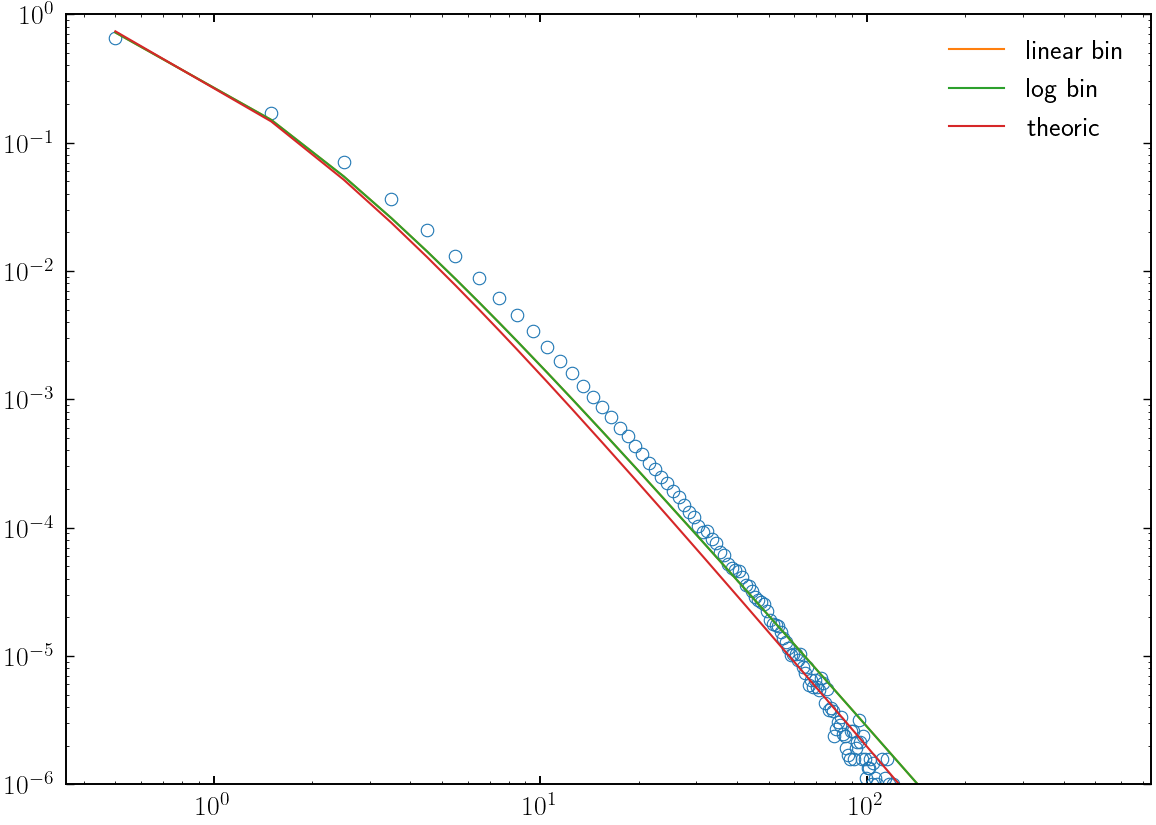

In [29]:
k,pk = k_2d_g[0], pk_2d_g[0]

mean_q, std_q_total, mean_b, std_b_total = bootstrap_q_exp(k_2d_g, pk_2d_g, 2, alpha_a=2.0, n_bootstrap=10**4)
mean_q_log, std_q_total_log, mean_b_log, std_b_total_log = bootstrap_q_exp(k_2d_g_log, pk_2d_g_log, 2, alpha_a=2.0, n_bootstrap=10**4)

#Q, B = optimize_q_exp(k, pk, q_initial=q(2.0,1), b_initial=eta(2.0,1), delta_q=0.01, delta_b=0.01)

#print(Q, B)
markersize = 9
print(f"q = {mean_q}, err_q = {(std_q_total/mean_q)*100}, b= {mean_b}, err_b = {(std_b_total/mean_b)*100}")
print(f"q = {mean_q_log}, err_q = {(std_q_total_log/mean_q_log)*100}, b= {mean_b_log}, err_b = {(std_b_total/mean_b_log)*100}")
plt.plot(k, pk,'o', ms=markersize)
plt.plot(k, q_exp(k, mean_q, mean_b),label='linear bin')
plt.plot(k, q_exp(k, mean_q_log, mean_b_log),label='log bin')
plt.plot(k, q_exp(k, q(2,2), eta(2,2)),label='theoric')
plt.xscale("log")
plt.yscale("log")
plt.ylim([10**(-6),1])

plt.legend()
plt.show()

In [30]:
q_1d, err_1d_q, b_1d, err_1d_b = bootstrap_q_exp(k_1d_g, pk_1d_g, dim = 1, alpha_a=2.0, n_bootstrap=10000)
q_2d, err_2d_q ,b_2d, err_2d_b = bootstrap_q_exp(k_2d_g, pk_2d_g, dim = 2, alpha_a=2.0, n_bootstrap=10000)
q_3d, err_3d_q, b_3d, err_3d_b = bootstrap_q_exp(k_3d_g, pk_3d_g, dim = 3, alpha_a=2.0, n_bootstrap=10000)
q_4d, err_4d_q, b_4d, err_4d_b = bootstrap_q_exp(k_4d_g, pk_4d_g, dim = 4, alpha_a=2.0, n_bootstrap=10000)

In [31]:
q_1d_log, err_1d_q_log, b_1d_log, err_1d_b_log = bootstrap_q_exp(k_1d_g_log, pk_1d_g_log, dim = 1, alpha_a=2.0, n_bootstrap=10000)
q_2d_log, err_2d_q_log ,b_2d_log, err_2d_b_log = bootstrap_q_exp(k_2d_g_log, pk_2d_g_log, dim = 2, alpha_a=2.0, n_bootstrap=10000)
q_3d_log, err_3d_q_log, b_3d_log, err_3d_b_log = bootstrap_q_exp(k_3d_g_log, pk_3d_g_log, dim = 3, alpha_a=2.0, n_bootstrap=10000)
q_4d_log, err_4d_q_log, b_4d_log, err_4d_b_log = bootstrap_q_exp(k_4d_g_log, pk_4d_g_log, dim = 4, alpha_a=2.0, n_bootstrap=10000)

In [35]:
print(f"err_q_lin = {(err_4d_q/q_4d)*100}, err_q_log = {(err_4d_q_log/q_4d_log)*100}")
print(f"err_b_lin = {(err_4d_b/b_4d)*100}, err_b_log = {(err_4d_b_log/b_4d_log)*100}")

err_q_lin = 7.49642837542974, err_q_log = 7.5291226702342895
err_b_lin = 40.4334020797247, err_b_log = 66.74968317725487


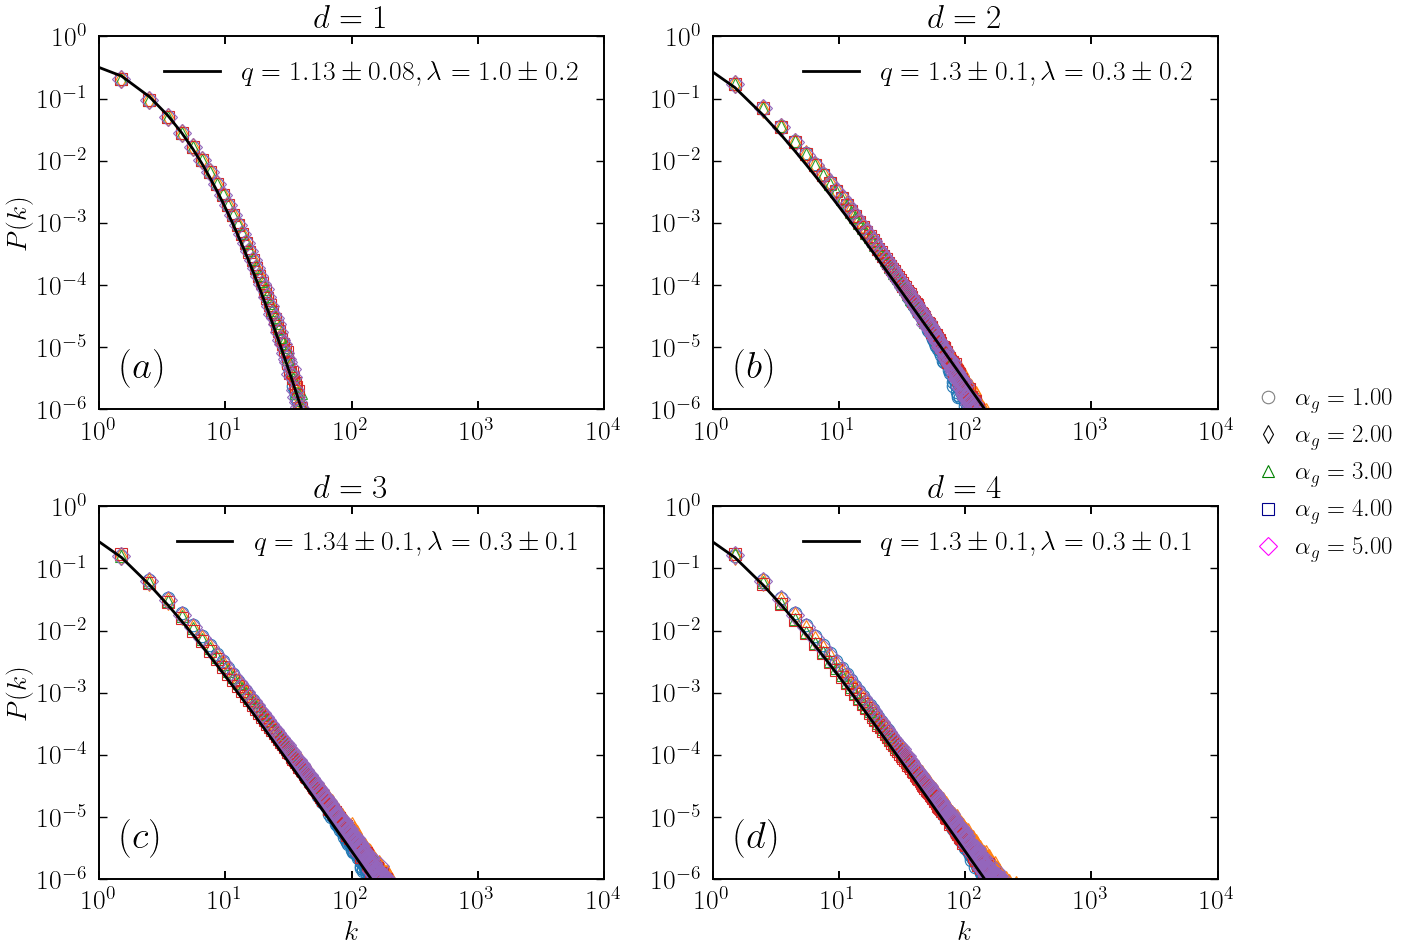

In [58]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]

labels_1 = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]

markers = ["o","d","^","s","D"]
dim = [1,2,3,4]
titles = [f"$d = {d}$" for d in dim]
labels_global = [rf"$\alpha_g = {alpha_g_v[i]:.2f}$" for i in range(len(alpha_g_v))]


fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_g_v)):
    # Plot data
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i],markers[i])
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i],markers[i])
    ax[1, 0].plot(k_3d_g[i], pk_3d_g[i],markers[i])
    ax[1, 1].plot(k_4d_g[i], pk_4d_g[i],markers[i])
 
label_1d, label_2d = f'$q = {q_1d:.2f} \pm {err_1d_q:.2f}, \\lambda$ $= {b_1d:.1f} \pm {err_1d_b:.1f}$', f'$q = {q_2d:.1f} \pm {err_2d_q:.1f}, \\lambda$ $= {b_2d:.1f} \pm {err_2d_b:.1f}$'
label_3d, label_4d = f'$q = {q_3d:.2f} \pm {err_3d_q:.1f}, \\lambda$ $= {b_3d:.1f} \pm {err_3d_b:.1f}$', f'$q = {q_4d:.1f} \pm {err_4d_q:.1f}, \\lambda$ $= {b_4d:.1f} \pm {err_4d_b:.1f}$'

ax[0, 0].plot(k_1d_g[1],q_exp(k_1d_g[1], q_1d, b_1d), label = label_1d, color="k", linewidth = 2.0)
ax[0, 1].plot(k_2d_g[1],q_exp(k_2d_g[1], q_2d, b_2d), label = label_2d, color="k", linewidth = 2.0)
ax[1, 0].plot(k_3d_g[1],q_exp(k_3d_g[1], q_3d, b_3d), label = label_3d, color="k", linewidth = 2.0)
ax[1, 1].plot(k_4d_g[1],q_exp(k_4d_g[1], q_4d, b_4d), label = label_4d, color="k", linewidth = 2.0)


ax[0, 0].text(1.5, 10**(-5.5), "$(a)$", style="normal" ,fontsize=28)
ax[0, 1].text(1.5, 10**(-5.5), "$(b)$", style="normal" ,fontsize=28)
ax[1, 0].text(1.5, 10**(-5.5), "$(c)$", style="normal" ,fontsize=28)
ax[1, 1].text(1.5, 10**(-5.5), "$(d)$", style="normal" ,fontsize=28)


# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_g_v))]

# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=18, frameon=False,handletextpad=0.1)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([1,10**4])
        ax[i, j].set_ylim([10**(-6),1])
        ax[i, j].set_title(titles[i*2+j])
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":18},fancybox=True,framealpha=0.0)
        ax[i, j].legend()
        ax[i, 0].set_ylabel(r"$P(k)$")
        ax[1, j].set_xlabel(r"$k$")
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
                
#fig.suptitle(r'Distribuição de graus para múltiplos $\alpha_g$', fontsize=30)
plt.tight_layout(rect=[0, 0, 0.86, 1])
plt.savefig("../../results/distributions/degree_alpha_g.pdf",dpi=300)
plt.show()

In [59]:
Q_1d, B_1d, Q_1d_err, B_1d_err = [], [], [], []
Q_2d, B_2d, Q_2d_err, B_2d_err = [], [], [], []
Q_3d, B_3d, Q_3d_err, B_3d_err = [], [], [], []
Q_4d, B_4d, Q_4d_err, B_4d_err = [], [], [], []

for i in range(len(alpha_a_v)):
    qq_1d, bb_1d, qq_1d_err, bb_1d_err = optimize_q_exp(k_1d_a_log[i], k_1d_a_log[i], q_initial=q(alpha_a_v[i], 1), b_initial=eta(alpha_a_v[i], 1), delta_q=0.01, delta_b=0.01)
    qq_2d, bb_2d, qq_2d_err, bb_2d_err = optimize_q_exp(k_2d_a_log[i], k_2d_a_log[i], q_initial=q(alpha_a_v[i], 2), b_initial=eta(alpha_a_v[i], 2), delta_q=0.01, delta_b=0.01)
    qq_3d, bb_3d, qq_3d_err, bb_3d_err = optimize_q_exp(k_3d_a_log[i], k_3d_a_log[i], q_initial=q(alpha_a_v[i], 3), b_initial=eta(alpha_a_v[i], 3), delta_q=0.01, delta_b=0.01)
    qq_4d, bb_4d, qq_4d_err, bb_4d_err = optimize_q_exp(k_4d_a_log[i], k_4d_a_log[i], q_initial=q(alpha_a_v[i], 4), b_initial=eta(alpha_a_v[i], 4), delta_q=0.01, delta_b=0.01)

    Q_1d.append(float(qq_1d))
    Q_2d.append(float(qq_2d))
    Q_3d.append(float(qq_3d))
    Q_4d.append(float(qq_4d))
    
    B_1d.append(float(bb_1d))
    B_2d.append(float(bb_2d))
    B_3d.append(float(bb_3d))
    B_4d.append(float(bb_4d))
    
    Q_1d_err.append(float(qq_1d_err))
    Q_2d_err.append(float(qq_2d_err))
    Q_3d_err.append(float(qq_3d_err))
    Q_4d_err.append(float(qq_4d_err))
    
    B_1d_err.append(float(bb_1d_err))
    B_2d_err.append(float(bb_2d_err))
    B_3d_err.append(float(bb_3d_err))
    B_4d_err.append(float(bb_4d_err))

markers = ["o","d","^","s","D","*","H","p","P"]

labels_global = [rf"$\alpha_a = {alpha_a_v[i]:.2f}$" for i in range(len(alpha_a_v))]
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
markersize = 9
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_a_v)):    
    # Plot data
    ax[0, 0].plot(k_1d_a[i], pk_1d_a[i], markers[i])
    ax[0, 1].plot(k_2d_a[i], pk_2d_a[i], markers[i])
    ax[1, 0].plot(k_3d_a[i], pk_3d_a[i], markers[i])
    ax[1, 1].plot(k_4d_a[i], pk_4d_a[i], markers[i])
    
    # ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    
    ax[0, 0].plot(k_1d_a[i], q_exp(k_1d_a[i], qq_1d, bb_1d), color=color[i],label=rf'$q = {qq_1d:.2f}, \lambda = {bb_1d:.2f}$', linewidth=1.4)
    ax[0, 1].plot(k_2d_a[i], q_exp(k_2d_a[i], qq_2d, bb_2d), color=color[i],label=rf'$q = {qq_2d:.2f}, \lambda = {bb_2d:.2f}$', linewidth=1.4)
    ax[1, 0].plot(k_3d_a[i], q_exp(k_3d_a[i], qq_3d, bb_3d), color=color[i],label=rf'$q = {qq_3d:.2f}, \lambda = {bb_3d:.2f}$', linewidth=1.4)
    ax[1, 1].plot(k_4d_a[i], q_exp(k_4d_a[i], qq_4d, bb_4d), color=color[i],label=rf'$q = {qq_4d:.2f}, \lambda = {bb_4d:.2f}$', linewidth=1.4)

        
# ax[0, 0].plot(k_1d_a[0],q_exp(k_1d_a[0], Q_1d, B_1d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[0, 1].plot(k_2d_a[0],q_exp(k_2d_a[0], Q_2d, B_2d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[1, 0].plot(k_3d_a[0],q_exp(k_3d_a[0], Q_3d, B_3d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[1, 1].plot(k_4d_a[0],q_exp(k_4d_a[0], Q_4d, B_4d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)

# Dimension Values
# ax[0, 0].text(1.7, 10**(-5.5), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
# ax[0, 1].text(1.7, 10**(-5.5), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
# ax[1, 0].text(1.7, 10**(-5.5), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
# ax[1, 1].text(1.7, 10**(-5.5), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})

ax[0, 0].text(1.7, 10**(-5.5), "$(a)$", style="normal" ,fontsize=25)
ax[0, 1].text(1.7, 10**(-5.5), "$(b)$", style="normal" ,fontsize=25)
ax[1, 0].text(1.7, 10**(-5.5), "$(c)$", style="normal" ,fontsize=25)
ax[1, 1].text(1.7, 10**(-5.5), "$(d)$", style="normal" ,fontsize=25)

# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_a_v))]

# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=17, frameon=False)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([1,10**4])
        ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        ax[i, j].set_title(titles[i*2+j])
        ax[i, j].legend(prop={"size":15})
        ax[i, 0].set_ylabel(r"$P(k)$")
        ax[1, j].set_xlabel(r"$k$")
        #ax[i, j].tick_params('both', labelsize=21)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())

#fig.suptitle(r'Distribuição de graus para múltiplos $\alpha_a$', fontsize=30)
plt.tight_layout(rect=[0, 0, 0.85, 1])
#plt.savefig("../../results/distributions/degree_alpha_a.pdf",dpi=300)
plt.show()

ValueError: too many values to unpack (expected 2)

In [30]:
k_1d_g, pk_1d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g, pk_2d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g, pk_3d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g, pk_4d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a, pk_1d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a, pk_2d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a, pk_3d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a, pk_4d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [31]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')

    k_1d_g[i], pk_1d_g[i] = df_1d["ds"], df_1d["pds"]
    k_2d_g[i], pk_2d_g[i] = df_2d["ds"], df_2d["pds"]
    k_3d_g[i], pk_3d_g[i] = df_3d["ds"], df_3d["pds"]
    k_4d_g[i], pk_4d_g[i] = df_4d["ds"], df_4d["pds"]

In [32]:
for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')

        k_1d_a[i], pk_1d_a[i] = df_1d["ds"], df_1d["pds"]
        k_2d_a[i], pk_2d_a[i] = df_2d["ds"], df_2d["pds"]
        k_3d_a[i], pk_3d_a[i] = df_3d["ds"], df_3d["pds"]
        k_4d_a[i], pk_4d_a[i] = df_4d["ds"], df_4d["pds"]

In [ ]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]
markers = ["o","d","^","s","D"]
#markers = ["o","o","o","o","o"]
labels_global = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]
markersize = 9
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_g_v)):
     # Plot data
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i],markers[i])
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i],markers[i])
    ax[1, 0].plot(k_3d_g[i], pk_3d_g[i],markers[i])
    ax[1, 1].plot(k_4d_g[i], pk_4d_g[i],markers[i])

thickness_axes =  2.4
parts_of_graphic = ['top', 'bottom', 'left', 'right']
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_g_v))]
# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=18, frameon=False)

for f, d in zip(ax.flatten(), dim):
    f.set_title(f"$d = {d}$")

ax[0, 0].text(10**(5.2), 10**(-1.8), "$(a)$", style="normal" ,fontsize=25)
ax[0, 1].text(10**(5.2), 10**(-1.5), "$(b)$", style="normal" ,fontsize=25)
ax[1, 0].text(10**5.1, 10**(-1.4), "$(c)$", style="normal" ,fontsize=25)
ax[1, 1].text(10**5.5, 10**(-1.3), "$(d)$", style="normal" ,fontsize=25)


# ax[0, 0].text(10**(5.2), 10**(-2.0), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
# ax[0, 1].text(10**(5.2), 10**(-1.5), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
# ax[1, 0].text(10**(5.1), 10**(-1.4), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
# ax[1, 1].text(10**(5.5), 10**(-1.3), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})

for i in range(2):
    for j in range(2):
        #ax[i, j].set_xlim([1,10**4])
        #ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$")
        ax[1, j].set_xlabel(r"$\Delta s$")
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_g_N100000.pdf")
plt.show()

In [ ]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod","purple","royalblue", "silver"]

markers = ["o","d","^","s","D","*","H","p","P"]
labels_global = [rf"$\alpha_a = {alpha_a_v[i]:.2f}$" for i in range(1, len(alpha_a_v))]
#markers = ["o","o","o","o","o"]
labels_1 = [rf"$\alpha_a = {alpha_a_v[i]:.2f}$" for i in range(1,len(alpha_a_v))]
markersize = 9
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(1,len(alpha_a_v)):
     # Plot data
    ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i])
    ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i])
    ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i])
    ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i])

thickness_axes =  2.4
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_a_v))]
# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=18, frameon=False)

ax[0, 0].text(10**(3), 10**(-2.0), "$(a)$", style="normal" ,fontsize=25)
ax[0, 1].text(10**(3), 10**(-1.41), "$(b)$", style="normal" ,fontsize=25)
ax[1, 0].text(10**3.3, 10**(-1.28), "$(c)$", style="normal" ,fontsize=25)
ax[1, 1].text(10**3.3, 10**(-1.10), "$(d)$", style="normal" ,fontsize=25)

# ax[0, 0].text(10**(2.8), 10**(-2.0), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
# ax[0, 1].text(10**(2.8), 10**(-1.41), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
# ax[1, 0].text(10**(3.2), 10**(-1.28), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
# ax[1, 1].text(10**(3.2), 10**(-1.10), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})

for f, d in zip(ax.flatten(), dim):
    f.set_title(f"$d = {d}$", fontsize=18)

parts_of_graphic = ['top', 'bottom', 'left', 'right']
for i in range(2):
    for j in range(2):
        #ax[i, j].set_xlim([1,10**4])
        #ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$")
        ax[1, j].set_xlabel(r"$\Delta s$")
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_a_N100000.pdf")
plt.show()